# Create a hierarchical clustering plot of your chosen features

In a previous exercise, you created a subset of the ABCD 3.0 release that included 1,000 randomly chosen subjects and 20 hand selected features.

After this notebook is run you should be able to:
1. summarize the datatypes of the features that you selected.
1. inspect correlations between your selected features.
1. install and import a new python library.
1. measure the similarity between two data records that contain both continuous and categorical data.
1. visualize this similarity using a hierarchical clustering plot

### Import all libraries
By convention all libraries being used are read in at the top of a notebook/script.

In [15]:
import matplotlib.pyplot as plt  # fine tune control over visualizations
import numpy as np  # to manipulate data/generate random numbers
import pandas as pd  # to read/manipulate/write data from files
import seaborn as sns  # static visualizations

from scipy.cluster.hierarchy import cophenet, linkage, dendrogram  # to perform cluster analysis
from scipy.spatial.distance import pdist, squareform  # to calculate distances and convert between condensed and square forms of a distance matrix
from sklearn.preprocessing import MinMaxScaler  # To standardize our data before clustering

Let's recover the subset data that you saved in a previous exercise. You saved that file with something like
```
subset_df.to_csv("my_dataset.tsv", sep="\t", index=None)
```
Can you use the pandas `pd.read_csv` function to load your subset data into the dataframe `subset_df`?
<details>
<summary>Hint</summary>
Try using `pd.read_csv()` with two of the arguments that you used to save the file.
</details>

In [21]:
# Insert code to load "my_dataset.tsv" as a pandas dataframe into the variable `subset_df`.
subset_df= pd.read_csv('/home/jovyan/my_dataset.tsv', sep='\t')

Let's look at the first five rows of our data just to remind ourselves of what's in there.

In [22]:
subset_df.head()

,subjectkey,interview_date,interview_age,sex,site_id_l,anthroheightcalc,anthroweightcalc,ehi_y_ss_scoreb,neighborhood_crime_y,snellen_aid_y,...,ksads_25_33_t,ksads_13_929_t,pps_y_ss_severity_score,prosocial_q2_y,prosocial_q3_y,fit_ss_sleepperiod_minutes,fit_ss_avg_hr_deep,smri_vol_cdk_total,smri_vol_scs_amygdalalh,mri_info_manufacturer
0,NDAR_INVCHLG4G6P,09/22/2017,120,F,site08,54.0,59.0,1,5.0,0.0,...,555,555,0.0,2.0,2.0,527.5,65.0,550238.0,1216.1,GE MEDICAL SYSTEMS
1,NDAR_INVB7PW7GZA,05/27/2017,125,F,site19,53.0,68.0,1,3.0,1.0,...,555,555,0.0,1.0,2.0,386.5,71.0,561102.0,1609.0,Philips Medical Systems
2,NDAR_INV13LFMTL6,10/20/2017,124,F,site08,56.7,74.5,2,5.0,0.0,...,555,555,0.0,1.0,1.0,505.0,70.0,683164.0,1448.3,GE MEDICAL SYSTEMS
3,NDAR_INVAKLPG0GB,08/24/2017,118,F,site19,54.5,67.0,1,5.0,0.0,...,555,555,6.0,1.0,2.0,433.5,63.0,529799.0,1586.0,Philips Medical Systems
4,NDAR_INV2BW6G83G,06/06/2017,131,F,site08,55.8,65.5,1,4.0,0.0,...,555,555,0.0,2.0,2.0,381.5,66.0,542857.0,1177.6,GE MEDICAL SYSTEMS


We see that "subjectkey" is one of the columns of our dataframe. We should make this column the "index" of the dataframe since each row corresponds to a unique subject ID.

In [23]:
subset_df.set_index("subjectkey", inplace=True)

Your `subset_df` dataframe should have a mix of continuous and categorical data.
Furthermore, the continuous data might be subdivided into integer and float datatypes.
Use the `info()` method of your pandas dataframe to inspect the datatypes of your
previously selected features.

In [24]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, NDAR_INVCHLG4G6P to NDAR_INV0AUBJJJ4
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   interview_date              1000 non-null   object 
 1   interview_age               1000 non-null   int64  
 2   sex                         1000 non-null   object 
 3   site_id_l                   1000 non-null   object 
 4   anthroheightcalc            1000 non-null   float64
 5   anthroweightcalc            1000 non-null   float64
 6   ehi_y_ss_scoreb             1000 non-null   int64  
 7   neighborhood_crime_y        1000 non-null   float64
 8   snellen_aid_y               1000 non-null   float64
 9   ksads_1_2_t                 1000 non-null   int64  
 10  ksads_8_29_t                1000 non-null   int64  
 11  ksads_25_33_t               1000 non-null   int64  
 12  ksads_13_929_t              1000 non-null   int64  
 13  pps_y_ss_se

Your data should be different because you chose different features in the previous exercise. Look at the penultimate line. In this example, we have
- nine (9) float type features
- six (6) integer type features
- four (4) "object" type features

Those "object" type features are strings that encode categorical data.

### Converting "objects" to "datetime" datatypes

But wait, "interview date" isn't simply categorical data. That column contains strings that represent dates and dates can be treated as different types of data depending on the context. For example, you could treat dates as nominal categorical data if you are only concerned with the day of the week of the interview date. Or you could treat dates as interval data; the starting point is arbitrary but the units are fixed, so that "12-24" is not the double of "6-12".

How you decide to use date data in your project is up to you, but in general it is good practice to let pandas know about date/time datatypes in your dataframe. Can you use the [`pd.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html#pandas-to-datetime) function to convert the "interview_date" column to a `datetime64` datatype?

<details>
<summary>Hint</summary>
You can modify columns in-place by using the pattern

`df["column_I_want_to_change"] = coversion_function(df["column_I_want_to_change"])`
</details>

In [40]:
# Insert code to convert the "interview_date" column to a datetime64 datetype.
subset_df["interview_date"] = pd.to_datetime(subset_df["interview_date"])

Now let's look at the first few rows again. You can see that the "interview_date" column entries changed format but the underlying content is preserved.

In [41]:
subset_df.head()

,interview_date,interview_age,sex,site_id_l,anthroheightcalc,anthroweightcalc,ehi_y_ss_scoreb,neighborhood_crime_y,snellen_aid_y,ksads_1_2_t,...,ksads_25_33_t,ksads_13_929_t,pps_y_ss_severity_score,prosocial_q2_y,prosocial_q3_y,fit_ss_sleepperiod_minutes,fit_ss_avg_hr_deep,smri_vol_cdk_total,smri_vol_scs_amygdalalh,mri_info_manufacturer
subjectkey,,,,,,,,,,,,,,,,,,,,,
NDAR_INVCHLG4G6P,2017-09-22,120,F,site08,54.0,59.0,1,5.0,0.0,0,...,555,555,0.0,2.0,2.0,527.5,65.0,550238.0,1216.1,GE MEDICAL SYSTEMS
NDAR_INVB7PW7GZA,2017-05-27,125,F,site19,53.0,68.0,1,3.0,1.0,1,...,555,555,0.0,1.0,2.0,386.5,71.0,561102.0,1609.0,Philips Medical Systems
NDAR_INV13LFMTL6,2017-10-20,124,F,site08,56.7,74.5,2,5.0,0.0,0,...,555,555,0.0,1.0,1.0,505.0,70.0,683164.0,1448.3,GE MEDICAL SYSTEMS
NDAR_INVAKLPG0GB,2017-08-24,118,F,site19,54.5,67.0,1,5.0,0.0,0,...,555,555,6.0,1.0,2.0,433.5,63.0,529799.0,1586.0,Philips Medical Systems
NDAR_INV2BW6G83G,2017-06-06,131,F,site08,55.8,65.5,1,4.0,0.0,0,...,555,555,0.0,2.0,2.0,381.5,66.0,542857.0,1177.6,GE MEDICAL SYSTEMS


And you can use `subset_df.info()` to confirm that "interview_date" now has the type `datetime64`.

In [42]:
subset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, NDAR_INVCHLG4G6P to NDAR_INV0AUBJJJ4
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   interview_date              1000 non-null   datetime64[ns]
 1   interview_age               1000 non-null   int64         
 2   sex                         1000 non-null   object        
 3   site_id_l                   1000 non-null   object        
 4   anthroheightcalc            1000 non-null   float64       
 5   anthroweightcalc            1000 non-null   float64       
 6   ehi_y_ss_scoreb             1000 non-null   int64         
 7   neighborhood_crime_y        1000 non-null   float64       
 8   snellen_aid_y               1000 non-null   float64       
 9   ksads_1_2_t                 1000 non-null   int64         
 10  ksads_8_29_t                1000 non-null   int64         
 11  ksads_25_33_t               1000 n

## Examining the correlations between different features

Now that we've prepared our subset dataframe, we'd like to understand which features are similar and which are dissimilar. We may wish to group certain features together and apply different rules to these separate groups rather that to the individual features. In machine learning, this process is called clustering and there is an expansive literature on the subject that is well beyond the scope of this notebook.

For our purposes, we will compute the similarity between different features and then visualize using a hierarchical clustering plot. We will call the similarity between two features (or two subjects for that matter) a "distance." When computing distances, it is important to standardize the data to avoid dependence on the datatypes or the choice of measurement units. We will attempt to standardize our data so that the maximum distance between subjects for any given feature is 1.0 and the minimum distance is 0.0.

### Categorical features

We will start by separating our subset data into different datatypes.

To begin with, let's separate out our categorical data. We can do this using the [`select_dtypes()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.select_dtypes.html#pandas-dataframe-select-dtypes) method of our `subset_df` dataframe.

In [43]:
cat_df = subset_df.select_dtypes(include=["object"])
cat_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, NDAR_INVCHLG4G6P to NDAR_INV0AUBJJJ4
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   sex                    1000 non-null   object
 1   site_id_l              1000 non-null   object
 2   mri_info_manufacturer  1000 non-null   object
dtypes: object(3)
memory usage: 31.2+ KB


In [45]:
cat_df.head()

,sex,site_id_l,mri_info_manufacturer
subjectkey,,,
NDAR_INVCHLG4G6P,F,site08,GE MEDICAL SYSTEMS
NDAR_INVB7PW7GZA,F,site19,Philips Medical Systems
NDAR_INV13LFMTL6,F,site08,GE MEDICAL SYSTEMS
NDAR_INVAKLPG0GB,F,site19,Philips Medical Systems
NDAR_INV2BW6G83G,F,site08,GE MEDICAL SYSTEMS


We can convert the text-based categorical features into a larger binary feature space using the [`pd.get_dummies()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html#pandas-get-dummies) function. This converts the categorical variables into indicator variables. We will use the `drop_first` parameter to get $k-1$ indicator variables out of $k$ categorical variables.

In [46]:
cat_features = pd.get_dummies(cat_df, drop_first=True)

In [47]:
cat_features

,sex_M,site_id_l_site10,site_id_l_site19,mri_info_manufacturer_Philips Medical Systems
subjectkey,,,,
NDAR_INVCHLG4G6P,0,0,0,0
NDAR_INVB7PW7GZA,0,0,1,1
NDAR_INV13LFMTL6,0,0,0,0
NDAR_INVAKLPG0GB,0,0,1,1
NDAR_INV2BW6G83G,0,0,0,0
...,...,...,...,...
NDAR_INVC0M1UAY5,0,1,0,0
NDAR_INV05LGG3GZ,1,0,0,0
NDAR_INVAKLPG0GB,0,0,1,1


### Numerical and ordinal features

Now we're going to select the numerical and ordinal features together. There is extensive debate in the mathematics and statistics communities on how best to treat ordinal data (e.g. treating it as qualitative or quantitative). The best answer is always ***it depends***. For pedagogical simplicity, we are going to combine the numerical and ordinal features and scale them to the range [0, 1].

Use the same `select_dtypes()` method to create a dataframe with the numerical and ordinal features. Store this dataframe in the variable `num_df`.

<details>
<summary>Hint</summary>
You can supply a list to `select_dtypes()` to select both the "int64" and "float64" types.
</details>

In [52]:
# Insert code to create `num_df` from only the numerical and ordinal features of `subset_df`.
num_df = subset_df.select_dtypes(include=["int64", "float64"])

Use the `info()` method to confirm that we selected only the features we want.

In [53]:
num_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, NDAR_INVCHLG4G6P to NDAR_INV0AUBJJJ4
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   interview_age               1000 non-null   int64  
 1   anthroheightcalc            1000 non-null   float64
 2   anthroweightcalc            1000 non-null   float64
 3   ehi_y_ss_scoreb             1000 non-null   int64  
 4   neighborhood_crime_y        1000 non-null   float64
 5   snellen_aid_y               1000 non-null   float64
 6   ksads_1_2_t                 1000 non-null   int64  
 7   ksads_8_29_t                1000 non-null   int64  
 8   ksads_25_33_t               1000 non-null   int64  
 9   ksads_13_929_t              1000 non-null   int64  
 10  pps_y_ss_severity_score     1000 non-null   float64
 11  prosocial_q2_y              1000 non-null   float64
 12  prosocial_q3_y              1000 non-null   float64
 13  fit_ss_slee

The estimable [scikit-learn library](https://sklearn.org/) provides many common utility functions for scaling and standardizing data. We will use the [`MinMaxScaler`](https://sklearn.org/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) to scale our numerical features to lie between zero and one.

In [54]:
# Scale standardisation of numerical values
minmax = MinMaxScaler(feature_range=(0, 1))

num_features = pd.DataFrame(
    minmax.fit_transform(num_df),
    index=num_df.index,
    columns=num_df.columns
)

And then concatenate our categorical and numerical features into a new dataframe called `df_scaled`.

In [55]:
df_scaled = pd.concat([num_features, cat_features], axis="columns")

# Confirm that all data lies between zero and one.
print(f"Data min, max: {df_scaled.min().min(), df_scaled.max().max()}")

Data min, max: (0.0, 1.0000000000000002)


### Choosing an appropriate distance metric

Finally, we need to provide some notion of distance between different points in our dataset. ***Different distances are appropriate for different datatypes.*** For example, it is common to use the Euclidean distance or Manhattan distance for numerical datatypes and dice distance for categorical variables. For those, you could rely on the scipy function [`scipy.spatial.distance.pdist`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) to generate the distance matrices.

Since we have a mix of categorical and numerical features, we will use the [Gower's distance](https://www.jstor.org/stable/2528823?seq=1), which was proposed in 1971 as a measure of dissimilarity with mixed types of variables.

We could write our own Python function to compute the Gower's distance, but one should always ask ***"is there a pre-existing package that will do this for me?"*** And of course, the answer is YES. There is a package called `gower` that will compute the Gower's distance matrix for us. It isn't available on the jupyterhub by default (and you might not have it on your local system).

But we can install software without ever leaving the jupyter notebook. You can execute Terminal commands in the notebook cells by prepending an exclamation point/bang(!) to the beginning of the command. Let's install the gower package.

In [56]:
!pip install gower

Now that we have `gower` installed, let's import it.

In [57]:
import gower

Great! Let's compute that distance matrix. One commonly seen convention is to name the distance matrix `Y` and, later on, name the hierarchical clustering data `Z`.

In a typical use case, one wishes to cluster individuals into different groups and we would do this by passing in the feature matrix stored in `df_scaled`. However, because we are clustering features, not subjects, we will pass in the transpose of the feature matrix. You can get the transpose of `df_scaled` using the `.T` attribute.

In [58]:
# Get the Gower's distance matrix
Y = gower.gower_matrix(df_scaled.T).astype(np.float64)

Let's quickly examine the structure of the distance matrix using matplotlib's `plt.matshow()` function. We can see that there is apparent banding in the distance matrix.

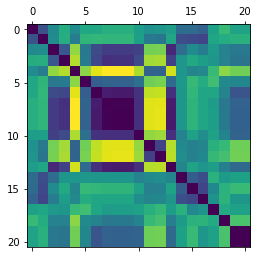

In [59]:
plt.matshow(Y)

There's a better way to visualize clustering in this distance matrix. The scipy library has a function, `scipy.cluster.hierarchy.linkage` which will perform hierarchical/agglomerative clustering given a distance matrix. It requires the distance matrix to be in "condensed" form and scipy also gives us a handy convenience function to covert from our "uncondensed" distance matrix to a condensed array.

In [60]:
# That result was in "uncondensed form". Let's use a scipy convenience
# function to convert it into a condensed array form. This stores only
# the upper triangular part since `Y` is a symmetric matrix.
Y = squareform(Y)

Now we can use `linkage` to perform the hierarchical clustering of our feature space.

In [61]:
Z = linkage(Y, method="complete", optimal_ordering=True)

$Z$ is a $(p - 1) \times 4$ matrix, where $p$ is the number of features in our scaled dataset. Here's how to interpret $Z$:
- At the $i$-th iteration, the sub-clusters with indices $Z[i, 0]$ and $Z[i, 1]$ combine to form a new cluster.
- If $Z[i, 0]$ or $Z[i, 1]$ is less than $p$, then that index refers to one of the original features
- The distance between clusters $Z[i, 0]$ and $Z[i, 1]$ is stored in $Z[i, 2]$.
- The fourth value $Z[i, 3]$ contains the number of original observations in the newly formed cluster.

That sounds like pretty complicated output, but we can use scipy's `dendrogram` function to visualize the heirarchical clustering using a [dendrogram](https://en.wikipedia.org/wiki/Dendrogram). The height of each bracket is representative of the distance between features or subclusters.

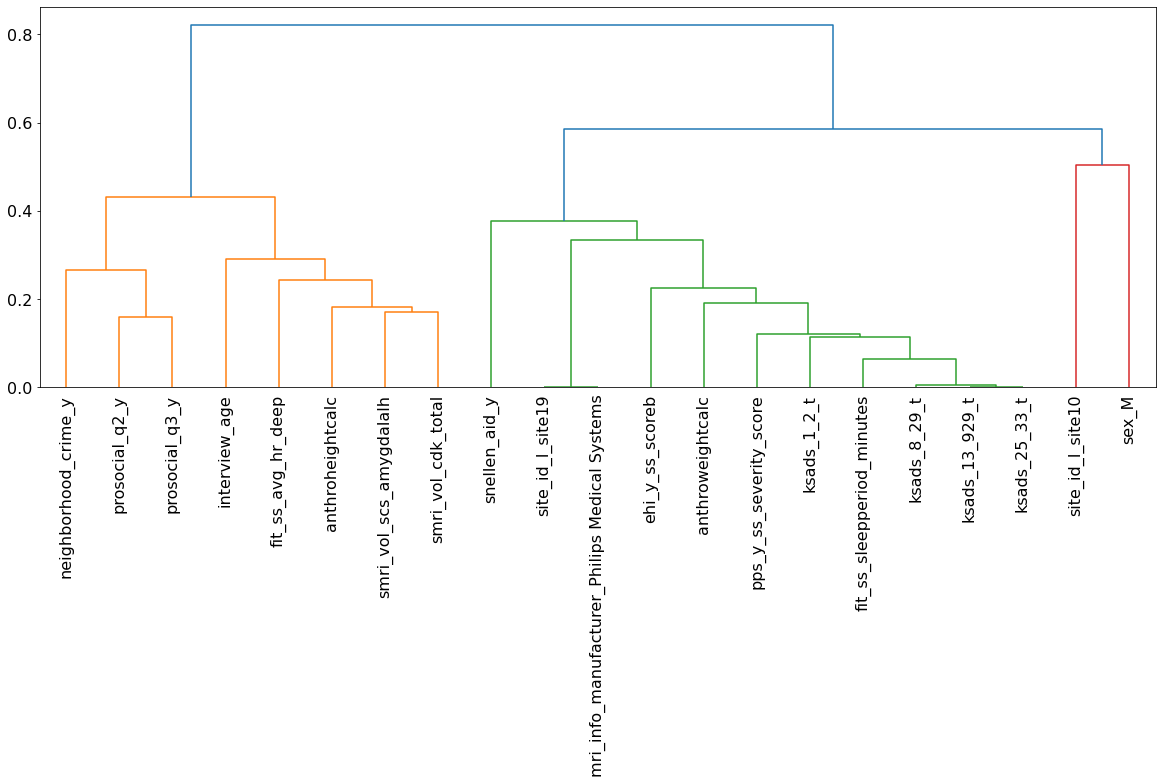

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
dn = dendrogram(
    Z,
    ax=ax,
    orientation="top",
    distance_sort='descending',
    show_leaf_counts=True,
)

# `dn["ivl"] stores a list of the feature indices in the order they appear on the x axis.
# Let's label the x-axis using the actual feature names rather than the indices
_ = ax.set_xticklabels(
    [list(df_scaled.columns)[int(i)] for i in dn["ivl"]],
    rotation=90,
    fontsize=16,
)

yticks = np.linspace(0.0, 0.8, 5)
_ = ax.set_yticks(yticks)
_ = ax.set_yticklabels([round(y, 1) for y in yticks], fontsize=16)

There's a lot going on here. One thing we notice immediately is that there are two pairs of KSADS features with zero distance between them. That is, the length of the vertical lines connecting ["ksads_13_929_t", "ksads_25_33_t] and ["ksads_1_2_t", "ksads_8_29_t] are negligible. We can verify this using seaborn's `pairplot` function.

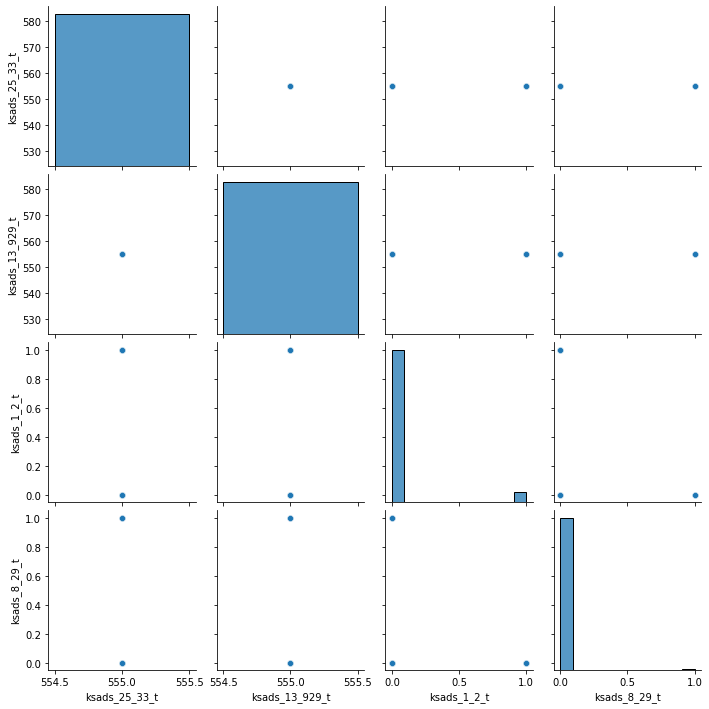

In [63]:
_ = sns.pairplot(
    subset_df,
    vars=["ksads_25_33_t", "ksads_13_929_t", "ksads_1_2_t", "ksads_8_29_t"]
)

And we can strengthen our intuition about this perfect correlation by viewing the data structure on NDA:

https://nda.nih.gov/data_structure.html?short_name=abcd_ksad501

For your own data subset, use the dendrogram to identify highly correlated features. Find those features using the NDA data query and address their correlation in the text box below. It is prepopulated with an example for this subset of features but you should write your own using your selected features.

> The two correlated pairs are:
> 
> - "ksads_25_33_t": Symptom - Failure to speak in social situations, Past
> - "ksads_13_929_t": Diagnosis - Anorexia Nervosa (F50.02) Binge eating/purging subtype, PRESENT
> 
> and
> 
> - "ksads_1_2_t": Symptom - Depressed Mood, Past
> - "ksads_8_29_t": Symptom - Fear of Social Situations Present
> 
> It seems reasonable to expect high comorbidity in these two pairs of features.
> 
> Additionally, as expected, we see that the one-hot-encoded features for Site ID are well correlated.
> 
> Lastly, we see that the "mri_info_manufacturer_Philips Medical Systems" indicator feature is first clustered with the indicator variable for "site17". This makes sense since the Philips Medical Systems scanners are only located at three sites in our subset, and most of the subjects scanned on them came from "site17" (see histogram below).

***Insert your own explanation below this line.***







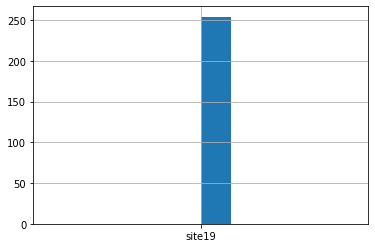

In [64]:
_ = subset_df[subset_df["mri_info_manufacturer"] == "Philips Medical Systems"]["site_id_l"].hist()

## With great power...

Lastly, you can see there are a lot of choices here:
- How do you treat ordinal data?
- How do you scale or standardize your data?
- Which distance metric is most appropriate?
- What linkage method should you use for hierarchical clustering?
Scipy makes it very easy to do the clustering, but it's up to you to make the choices and understand the implications. 

One thing you can do to check for internal consistency of your choice of metric is check the [Cophenetic Correlation Coefficient](https://en.wikipedia.org/wiki/Cophenetic_correlation) of your clustering with help of the [`cophenet()`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.cophenet.html) function. This compares the actual pairwise distances of your data to those computed by the hierarchical clustering. The closer the value is to 1, the better the clustering preserves the original distances.

In our case, since `Z` was computed using the Gower distance, which combined the Manhattan (or "cityblock") distance for numerical values and the dice distance for categorical values, we will calculate the cophenetic correlation coefficient between our clustering distances and the "cityblock" distance using the [`pdist()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html#scipy.spatial.distance.pdist) function.

In [65]:
c, coph_dists = cophenet(Z, pdist(df_scaled.T.values, "cityblock"))
print(f"Cophenetic correlation coefficient: {c}")

Cophenetic correlation coefficient: 0.8632228783538238


And we see that the clustering distances are pretty close to the pairwise Manhattan distances.

Compute the cophenetic correlation coefficient for your choice of linkage method and distance metric.